In [1]:
%matplotlib inline

import os,sys
import gc

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

import torch
from torch.autograd import Variable

import timeit

%load_ext autoreload
%autoreload 2

# Loading the files for training

In [2]:
# Directory and files name
train_dir = "training/"
tr_image_dir = train_dir + "images/"
tr_label_dir = train_dir + "groundtruth/"

tr_image_files = os.listdir(tr_image_dir)
tr_label_files = os.listdir(tr_label_dir)

# Number of training samples
N = len(tr_image_files)

# Load the images and ground truth
img_train = []
label_train = []
for i in range(N):
    img = mpimg.imread(tr_image_dir + tr_image_files[i])
    label = mpimg.imread(tr_label_dir + tr_label_files[i])
    
    img_train.append(img)
    label_train.append(label)

# Keep only sub-set of images
NUM_IMAGES = N

img_train = np.asarray(img_train[:NUM_IMAGES])
label_train = np.asarray(label_train[:NUM_IMAGES])

print(img_train.shape, label_train.shape)

(100, 400, 400, 3) (100, 400, 400)


In [3]:
PATCH_SIZE = 16

In [341]:
def img_crop(im, w, h):
    list_patches = []
    imgwidth = im.shape[0]
    imgheight = im.shape[1]
    is_2d = len(im.shape) < 3
    for i in range(0,imgheight,h):
        for j in range(0,imgwidth,w):
            if is_2d:
                im_patch = im[j:j+w, i:i+h]
            else:
                im_patch = im[j:j+w, i:i+h, :]
            list_patches.append(im_patch)
    return list_patches

def extract_data(filename, num_images):
    """Extract the images into a 4D tensor [image index, y, x, channels].
    Values are rescaled from [0, 255] down to [-0.5, 0.5].
    """
    imgs = []
    tmp_imgs = []
    for i in range(1, num_images+1):
        imageid = "satImage_%.3d" % i
        image_filename = filename + imageid + ".png"
        if os.path.isfile(image_filename):
            print ('Loading ' + image_filename)
            img = Image.open(image_filename)
            tmp_imgs.append(img)
        else:
            print ('File ' + image_filename + ' does not exist')

    num_images = len(tmp_imgs)
    for i in range(num_images):
        imgs.append(np.asarray(tmp_imgs[i]) / 255)
        imgs.append(np.asarray(tmp_imgs[i].rotate(90)) / 255)
        imgs.append(np.asarray(tmp_imgs[i].rotate(180)) / 255)
        imgs.append(np.asarray(tmp_imgs[i].rotate(-90)) / 255)
        imgs.append(np.asarray(tmp_imgs[i].transpose(Image.FLIP_LEFT_RIGHT)) / 255)
        imgs.append(np.asarray(tmp_imgs[i].transpose(Image.FLIP_TOP_BOTTOM)) / 255)
        imgs.append(np.asarray(tmp_imgs[i].transpose(Image.TRANSPOSE)) / 255)
    num_images = len(imgs)
    IMG_WIDTH = imgs[0].shape[0]
    IMG_HEIGHT = imgs[0].shape[1]
    N_PATCHES_PER_IMAGE = (IMG_WIDTH/IMG_PATCH_SIZE)*(IMG_HEIGHT/IMG_PATCH_SIZE)
    print('Patches per images: ' + str(N_PATCHES_PER_IMAGE))

    img_patches = [img_crop(imgs[i], IMG_PATCH_SIZE, IMG_PATCH_SIZE) for i in range(num_images)]

    data = np.array([img_patches[i][j] for i in range(len(img_patches)) for j in range(len(img_patches[i]))])

    return data

# Assign a label to a patch v
def value_to_class(v):
    foreground_threshold = 0.25 # percentage of pixels > 1 required to assign a foreground label to a patch
    df = np.sum(v)
    if df > foreground_threshold:
        return 1 #return [0, 1]
    else:
        return 0 #return [1, 0]

def enhance_save(train_data, train_labels):
    data_copy = list(train_data)
    path = './windows_train_patch/'
    os.makedirs(path, exist_ok=True)
    for ind, im in enumerate(data_copy):
        cur_name = path + str(ind)
        plt.imsave(cur_name + "_" + str(train_labels[ind]) + ".png", im)
        plt.imsave(cur_name + "_" + str(train_labels[ind]) + "r90.png", np.rot90(im))
        plt.imsave(cur_name + "_" + str(train_labels[ind]) + "r180.png", np.rot90(im,k=2))        
        plt.imsave(cur_name + "_" + str(train_labels[ind]) + "r270.png", np.rot90(im,k=3))
        plt.imsave(cur_name + "_" + str(train_labels[ind]) + "flr.png", np.fliplr(im))
        plt.imsave(cur_name + "_" + str(train_labels[ind]) + "fud.png", np.flipud(im))
        plt.imsave(cur_name + "_" + str(train_labels[ind]) + "tr.png", np.transpose(im,(1, 0, 2)))
    
    del data_copy


# Extract label images
def extract_labels(filename, num_images):
    """Extract the labels into a 1-hot matrix [image index, label index]."""
    gt_imgs = []
    tmp_imgs = []
    for i in range(1, num_images+1):
        imageid = "satImage_%.3d" % i
        image_filename = filename + imageid + ".png"
        if os.path.isfile(image_filename):
            print ('Loading ' + image_filename)
            img = Image.open(image_filename)
            tmp_imgs.append(img)
        else:
            print ('File ' + image_filename + ' does not exist')

    num_images = len(tmp_imgs)
    for i in range(num_images):
        gt_imgs.append(np.asarray(tmp_imgs[i]) / 255)        
        gt_imgs.append(np.asarray(tmp_imgs[i].rotate(90)) / 255)
        gt_imgs.append(np.asarray(tmp_imgs[i].rotate(180)) / 255)
        gt_imgs.append(np.asarray(tmp_imgs[i].rotate(-90)) / 255)
        gt_imgs.append(np.asarray(tmp_imgs[i].transpose(Image.FLIP_LEFT_RIGHT)) / 255)
        gt_imgs.append(np.asarray(tmp_imgs[i].transpose(Image.FLIP_TOP_BOTTOM)) / 255)
        gt_imgs.append(np.asarray(tmp_imgs[i].transpose(Image.TRANSPOSE)) / 255)
    num_images = len(gt_imgs)
    gt_patches = [img_crop(gt_imgs[i], IMG_PATCH_SIZE, IMG_PATCH_SIZE) for i in range(num_images)]
    data = np.array([gt_patches[i][j] for i in range(len(gt_patches)) for j in range(len(gt_patches[i]))])
    labels = np.array([value_to_class(np.mean(data[i])) for i in range(len(data))])

    # Convert to dense 1-hot representation.
    return labels.astype(np.float32)

# Convert array of labels to an image
def label_to_img_win(imgwidth, imgheight, w, h, labels):
    array_labels = np.zeros([imgwidth, imgheight])
    idx = 0
    for i in range(0,imgheight,h):
        for j in range(0,imgwidth,w):
            if labels[idx] > 0.5:
                array_labels[i:i+w, j:j+h] = 1
            else:
                array_labels[i:i+w, j:j+h] = 0
            idx = idx + 1
    return array_labels

# Convert array of labels to an image
def label_to_img(imgwidth, imgheight, w, h, labels):
    array_labels = np.zeros([imgwidth, imgheight])
    idx = 0
    for i in range(0,imgheight,h):
        for j in range(0,imgwidth,w):
            if labels[idx] > 0.5:
                array_labels[j:j+w, i:i+h] = 1
            else:
                array_labels[j:j+w, i:i+h] = 0
            idx = idx + 1
    return array_labels

# Convert array of labels to an image
def label_to_img_soft(imgwidth, imgheight, w, h, labels):
    array_labels = np.zeros([imgwidth, imgheight])
    idx = 0
    for i in range(0,imgheight,h):
        for j in range(0,imgwidth,w):
            array_labels[j:j+w, i:i+h] = labels[idx]
            idx = idx + 1
    return array_labels

def img_float_to_uint8(img):
    rimg = img - np.min(img)
    rimg = (rimg / np.max(rimg) * PIXEL_DEPTH).round().astype(np.uint8)
    return rimg

In [5]:
# Compute features for each image patch
foreground_threshold = 0.25 # percentage of pixels > 1 required to assign a foreground label to a patch

def value_to_class(v):
    df = np.sum(v)
    if df > foreground_threshold:
        return 1
    else:
        return 0

label_train = [value_to_class(np.mean(label_train[i])) for i in range(len(label_train))]

# Enhance the training dataset w/ sliding windows

In [6]:
IMG_SIZE = 400
WINDOW_SIZE = 52 # 18px - PATCH_SIZE - 18px
NB_WINDOWS = (IMG_SIZE/PATCH_SIZE)**2

In [7]:
def apply_mirror_boundary_conditions(coord, dim):
    """
    Return the correct coordinate according to mirror boundary conditions
        coord: a coordinate (x or y) in the image
        dim: the length of the axis of said coordinate
    """
    # If the coordinate is outside of the bounds of the axis, take its reflection inside the image
    if coord < 0:
        coord = -coord
    elif coord >= dim:
        coord =  2*(dim-1) - coord % (2*(dim-1))
    # Else, do nothing
    return int(coord)

def get_window(image, window_size, corner_coordinates, patch_size):
    """
    Get a window in image, centered on a patch, taking into account boundary conditions
        image: a numpy array representing our image
        window_size: an even number specifying the size of the window
        corner_coordinates: a list containing the x-y coordinates of the patch's upleft pixel
        path_size: an even number specifying the size of the central patch
    """
    # Get convenient variables
    window_radius = window_size/2
    border_size = (window_size - patch_size)/2
    i_patch_corner, j_patch_corner = (corner_coordinates[0], corner_coordinates[1])
    i_window_corner, j_window_corner = (i_patch_corner - border_size, j_patch_corner - border_size)
    nrows, ncols, nchannels = image.shape
    window = np.zeros((window_size, window_size, nchannels))
    
    # Fill in the window array with pixels of the image
    for i in range(window_size):
        # Apply mirror boundary conditions on the x-coordinate
        i_mirrored = apply_mirror_boundary_conditions(i_window_corner + i, nrows)
        for j in range(window_size):
            # Same for the y-coordinate
            j_mirrored = apply_mirror_boundary_conditions(j_window_corner + j, ncols)
            # Fill in the window with the corresponding pixel
            window[i, j, :] = image[i_mirrored, j_mirrored, :]
    return window

In [8]:
def shift_to_the_right(image, window, corner_coordinates, patch_size):
    nrows, ncols, _ = image.shape
    window_size = len(window)
    #window_radius = window_size/2
    border_size = (window_size - patch_size)/2
    i_patch_corner, j_patch_corner = (corner_coordinates[0], corner_coordinates[1])
    i_window_corner, j_window_corner = (i_patch_corner - border_size, j_patch_corner - border_size)
    step = patch_size
    
    shifted = np.roll(window, -step, axis=1)
    for i in range(window_size):
        i_mirrored = apply_mirror_boundary_conditions(i_window_corner + i, nrows)            
        for j in range(window_size-step, window_size):
            j_mirrored = apply_mirror_boundary_conditions(j_window_corner + j + step, ncols)
            shifted[i, j, :] = image[i_mirrored, j_mirrored, :]
    return shifted

def shift_to_the_bottom(image, window, corner_coordinates, patch_size):
    nrows, ncols, _ = image.shape
    window_size = len(window)
    #window_radius = window_size/2
    border_size = (window_size - patch_size)/2
    i_patch_corner, j_patch_corner = (corner_coordinates[0], corner_coordinates[1])
    i_window_corner, j_window_corner = (i_patch_corner - border_size, j_patch_corner - border_size)
    step = patch_size
    
    shifted = np.roll(window, -step, axis=0)
    for j in range(window_size):
        j_mirrored = apply_mirror_boundary_conditions(j_window_corner + j, ncols)
        for i in range(window_size-step, window_size):
            i_mirrored = apply_mirror_boundary_conditions(i_window_corner + i + step, nrows)
            shifted[i, j, :] = image[i_mirrored, j_mirrored, :]
    return shifted

def sliding_window(image, window_size, patch_size):
    """
    Construct a list of sliding windows of given size on an image.
    The windows, centered on a patch, will slide from left to right and from up to down.
        image: a numpy array representing our image
        window_size: an even number specifying the size of the window
        patch_size: the size of the central patch
    """
    nrows, ncols, _ = image.shape
    windows = []
    i = 0
    row_windows = [get_window(image, window_size, [i, 0], patch_size)]
    for j in range(patch_size, ncols-1, patch_size):
        #print(j)
        row_windows += [shift_to_the_right(image, row_windows[-1], [i, j], patch_size)]
    windows += row_windows
    #print('===')
    for i in range(patch_size, nrows-1, patch_size):
        #print(i)
        row_windows = [shift_to_the_bottom(image, row_windows[int(j/patch_size)], [i, j], patch_size) 
                       for j in range(0, ncols-1, patch_size)]
        #print(len(row_windows))
        windows += row_windows
    return windows

In [9]:
def enhance(train_data):
    #print(len(train_data), train_data[0].shape)
    data_copy = list(train_data)
    
    train_data += [np.rot90(im) for im in data_copy]
    train_data += [np.rot90(im, k=2) for im in data_copy]
    train_data += [np.rot90(im, k=3) for im in data_copy]
    train_data += [np.fliplr(im) for im in data_copy]
    train_data += [np.flipud(im) for im in data_copy]
    train_data += [np.transpose(im, (1,0,2)) for im in data_copy]
    
    del data_copy
    gc.collect()

    return train_data

In [10]:
def compute(img_train, train_labels, window_size, patch_size):
    train_data = []
    nb_windows = (IMG_SIZE/patch_size)**2
    i = 0
    for im in img_train:
        print(i)
        #w_im = enhance(sliding_window(im, window_size, patch_size))
        w_im = sliding_window(im, window_size, patch_size)
        #w_labels = sliding_window(labels[:, :, np.newaxis], window_size, step)
        train_data += w_im
        i += 1
        #train_labels += w_labels
        #path = './windows_train_patch/' + str(i)
        #os.makedirs(path, exist_ok=True)
        #for wi, j in zip(w_im, range(len(w_im))):
            #img_name = path + '/im_' + str(j) + '.png'
            #plt.imsave(img_name, wi)
            #label_name = path + '/label_' + str(j) + '.png'
            #plt.imsave(label_name, wl[:,:,0])
    #train_labels *= 7
    
    return np.asarray(train_data).reshape((len(train_labels), window_size, window_size, 3)), np.asarray(train_labels)

In [11]:
#img_train, label_train = compute(img_train, label_train, WINDOW_SIZE, PATCH_SIZE)

In [12]:
#a = np.array(range(10*10))
#a = a.reshape((10, 10))
#print(a)
#aa = get_window(a[:,:,np.newaxis], 5, [5,5])[:,:,0]
#print('\n')
#print(aa)
#print('\n')
#print(shift_to_the_bottom(a[:,:,np.newaxis], aa[:,:,np.newaxis], [5,5], 2)[:,:,0])

# Neural networks

In [13]:
NUM_CHANNELS = 3 # RGB images
PIXEL_DEPTH = 255
NUM_LABELS = 2
#IMG_PATCH_SIZE = 52
#TRAINING_SIZE = 62500
BATCH_SIZE = 32
NUM_EPOCHS = 15
a = 0.00

In [14]:
import keras
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Flatten, LeakyReLU, Input, Reshape, Permute, Average
from keras.layers import Conv2D, MaxPooling2D, Concatenate, Lambda, Activation, GlobalAveragePooling2D, Conv2DTranspose, GlobalAveragePooling1D
from keras.optimizers import SGD, Adam

Using TensorFlow backend.


In [15]:
def model0(IMG_PATCH_SIZE, TRAINING_SIZE):
    model0 = Sequential()
    model0.add(Conv2D(32, 2, input_shape=(IMG_PATCH_SIZE, IMG_PATCH_SIZE, NUM_CHANNELS)))
    model0.add(LeakyReLU(alpha=a))
    model0.add(Conv2D(32, 2))
    model0.add(LeakyReLU(alpha=a))
    model0.add(MaxPooling2D(pool_size=(2, 2)))
    model0.add(Dropout(0.25))

    model0.add(Conv2D(64, 2))
    model0.add(LeakyReLU(alpha=a))
    model0.add(Conv2D(64, 2))
    model0.add(LeakyReLU(alpha=a))
    model0.add(MaxPooling2D(pool_size=(2, 2)))
    model0.add(Dropout(0.25))

    model0.add(Flatten())
    model0.add(Dense(128))
    model0.add(Dropout(0.5))
    model0.add(LeakyReLU(alpha=a))
    model0.add(Dense(1, activation='sigmoid'))
    
    return model0

In [16]:
from keras.engine.topology import Layer
def fire(x, squeeze, expand):
    x = Conv2D(squeeze, 1)(x)
    x = LeakyReLU(alpha=a)(x)
    e11 = Conv2D(expand, 1)(x)
    e11 = LeakyReLU(alpha=a)(e11)
    e33 = Conv2D(expand, 1)(x)
    e33 = LeakyReLU(alpha=a)(e33)
    return Concatenate(axis=3)([e11, e33])

In [17]:
def model1(IMG_PATCH_SIZE, TRAINING_SIZE):
    inputs = Input(shape=(IMG_PATCH_SIZE, IMG_PATCH_SIZE, NUM_CHANNELS))
    x = Conv2D(32, kernel_size=3, strides=2, input_shape=(IMG_PATCH_SIZE, IMG_PATCH_SIZE, NUM_CHANNELS))(inputs)
    x = LeakyReLU(alpha=a)(x)
    x = MaxPooling2D(pool_size=3, strides=2)(x)

    x = fire(x, squeeze=8, expand=16)
    x = fire(x, squeeze=8, expand=16)
    x = MaxPooling2D(pool_size=3, strides=2)(x)

    '''x = fire(x, squeeze=32, expand=128)
    x = fire(x, squeeze=32, expand=128)
    x = MaxPooling2D(pool_size=3, strides=2)(x)

    x = fire(x, squeeze=48, expand=192)
    x = fire(x, squeeze=48, expand=192)
    x = fire(x, squeeze=64, expand=256)
    x = fire(x, squeeze=64, expand=256)
    x = MaxPooling2D(pool_size=3, strides=2)(x)'''
    x = Flatten()(x)
    x = Dense(1, activation='sigmoid')(x)

    model1 = Model(inputs, x)
    return model1

In [18]:
def model2(IMG_PATCH_SIZE, TRAINING_SIZE):
    model2 = Sequential()
    model2.add(Conv2D(32, 2, input_shape=(IMG_PATCH_SIZE, IMG_PATCH_SIZE, NUM_CHANNELS)))
    model2.add(LeakyReLU(alpha=a))
    model2.add(Conv2D(32, 2))
    model2.add(LeakyReLU(alpha=a))
    model2.add(MaxPooling2D(pool_size=(2, 2)))
    model2.add(Dropout(0.25))

    model2.add(Conv2D(64, 2))
    model2.add(LeakyReLU(alpha=a))
    model2.add(Conv2D(64, 2))
    model2.add(LeakyReLU(alpha=a))
    model2.add(MaxPooling2D(pool_size=(2, 2)))
    model2.add(Dropout(0.25))

    model2.add(Conv2D(2, 1))
    model2.add(Conv2DTranspose(1, kernel_size=IMG_PATCH_SIZE - 1, padding='valid'))
    #model.add(Reshape((-1, IMG_PATCH_SIZE * IMG_PATCH_SIZE)))
    #model.add(Permute((2,1)))
    model2.add(GlobalAveragePooling2D())
    model2.add(Activation('sigmoid'))
    return model2

In [19]:
#for layer in model.layers:
    #print(layer.input_shape,layer.output_shape )

In [20]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall))

# Grid search

best_window_size = np.nan
best_model = np.nan
best_score = 0

LR = 0.001
DECAY = 0.00000
adam = Adam(lr=LR, decay=DECAY)

for window_size in range(30, 60, 2):
    imgs, labels = compute(img_train, label_train, window_size, PATCH_SIZE)
    training_size = imgs.shape[0]
    num_model = 0
    for model in [model0(window_size, training_size)]:#, model1(window_size, training_size), model2(window_size, training_size)]:
        model.compile(loss='binary_crossentropy', optimizer=adam, metrics=[f1])
        model.fit(imgs, labels, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS)
        score = model.evaluate(train, labels)[1]
        if score > best_score:
            best_score = score
            best_model = num_model
            best_window_size = window_size
        num_model += 1

In [224]:
from keras import backend as K

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall))


In [228]:
imgs, labels = compute(img_train, label_train, 16, PATCH_SIZE)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [229]:
#path = 'FCN_W32_noenh.h5'
path = 'FCN_16_enh.h5'
model = keras.models.load_model(path,custom_objects={'f1_score':f1})

C:\Users\MATT\Anaconda3\lib\site-packages\keras\models.py:288: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [230]:
predictions = model.predict(imgs)

In [252]:
def patch_predictions(predictions):
    predictions[predictions < 0.5] = 0
    predictions[predictions > 0] = 1
    nb_predictions = int(len(predictions)/NUM_IMAGES)
    pred = []
    for i in range(0, len(predictions), k):
        pred += [predictions[i:i+k].reshape((25, 25))]
    return pred

In [253]:
import scipy
from scipy import ndimage
import matplotlib.pyplot as plt

def remove_small_pieces(predictions, thresh_size=4):
    modified = []
    for p in predictions:
        # find connected components
        labeled, nr_objects = ndimage.label(p) 
        #print(nr_objects)
        areas = [len(np.where(labeled == i)[0]) for i in range(1, nr_objects+1)]
        #print(areas)
        smallest = np.where(np.array(areas) <= thresh_size)[0]
        #print(smallest)
        for i in smallest:
            labeled[np.where(labeled == i+1)] = 0
        modified += [labeled]
    return modified

In [254]:
def check_road(list_, length_road, max_hole):
    N = len(list_)
    roads = []
    end = []
    for i in range(N-length_road):
        #print(np.all(list_[i:i+length_road] > 0))
        roads += [np.all(list_[i:i+length_road] > 0)]
    for i in range(N, 0, -1):
        end += [np.all(list_[i-length_road:i] > 0)]
    roads += end[:length_road]
    roads = fill_holes(roads, max_hole)
    return roads

def fill_holes(list_, max_hole):
    idx = np.where(np.array(list_))[0]
    distances = idx[1:] - idx[0:-1]
    tofill = np.where(distances <= max_hole)[0]
    for i in tofill:
        list_[i] = True
    return list_

In [350]:
def detect_roads(predictions, length_road=5, max_hole=4):
    modified = []
    for p in predictions:
        L = []
        C = []
        for i in range(len(p)):
            L += [check_road(p[i, :], length_road, max_hole)]
            C += [check_road(p[:, i], length_road, max_hole)]
        L = np.asarray(L)
        C = np.asarray(C).T
        #print(L.shape, C.shape)
        roads = (L+C).astype(int)
        modified += [roads.T]
    return modified

In [256]:
def treat_predictions(predictions):
    return remove_small_pieces(detect_roads(patch_predictions(predictions))), detect_roads(remove_small_pieces(patch_predictions(predictions)))

In [257]:
pred_mod1, pred_mod2 = np.asarray(treat_predictions(predictions))

In [258]:
pred_mod1[pred_mod1 > 0] = 1
pred_mod2[pred_mod2 > 0] = 1

In [259]:
y_train = np.asarray(patch_predictions(labels))
pred = np.asarray(patch_predictions(predictions)).astype(int)
pred = np.transpose(pred, (0,2,1))

In [288]:
from sklearn.metrics import f1_score

f1_pred = 0
f1_mod1 = 0
f1_mod2 = 0

for i in range(y_train.shape[0]):
    f1_pred += f1_score(1-y_train[i].ravel(), 1-pred[i].ravel())
    f1_mod1 += f1_score(1-y_train[i].ravel(), 1-pred_mod1[i].ravel())
    f1_mod2 += f1_score(1-y_train[i].ravel(), 1-pred_mod2[i].ravel())

f1_pred /= y_train.shape[0]
f1_mod1 /= y_train.shape[0]
f1_mod2 /= y_train.shape[0]

print(f1_pred, f1_mod1, f1_mod2)

0.80986204025 0.839438421969 0.834165798626


In [289]:
score = 0
best_params = (0, 0, 0)

for area in range(1, 5):
    for road in range(1, 7):
        for hole in range(1, 7):
            e = np.asarray(remove_small_pieces(detect_roads(patch_predictions(predictions), road, hole), area))
            e[e > 0] = 1
            f1 = 0
            for i in range(y_train.shape[0]):
                f1 += f1_score(1-y_train[i].ravel(), 1-e[i].ravel())
            f1 /= y_train.shape[0]
            if f1 > score:
                score = f1
                best_params = (area, road, hole)

print(score, best_params)

0.851358397402 (4, 6, 1)


In [290]:
a = np.asarray(remove_small_pieces(detect_roads(patch_predictions(predictions), best_params[1], best_params[2]), best_params[0]))
a[a > 0] = 1

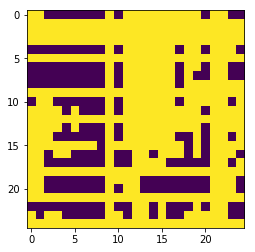

In [297]:
plt.imshow(a[77, :, :])

# Test

In [306]:
# Directory and files name
test_dir = "test_set_images/"

test_image_files = os.listdir(test_dir)

# Number of testing samples
N = len(test_image_files)

# Load the images and ground truth
img_test = []
for i in range(N):
    img = mpimg.imread(test_dir + test_image_files[i] + '/' + test_image_files[i] + '.png')
    
    img_test.append(img)

img_test = np.asarray(img_test)

print(img_test.shape)

(50, 608, 608, 3)


In [330]:
imgs = np.asarray(img_crop(img_test[0], PATCH_SIZE, PATCH_SIZE))

In [342]:
predictions = model.predict(imgs)
pred = label_to_img(608, 608, 16, 16, predictions)

In [364]:
a = np.asarray(remove_small_pieces(detect_roads([pred], best_params[1]*2, best_params[2]*2), best_params[0]*2))
a[a > 0] = 1

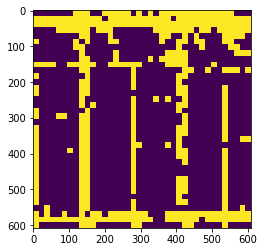

In [401]:
plt.imshow(pred)

In [416]:
import cv2

kernel = np.ones((5,5))
k2 = np.ones((20,20))
k3 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))

closing = cv2.morphologyEx(pred.astype(np.float32), cv2.MORPH_CLOSE, k2)
erosion = cv2.erode(closing, kernel, iterations = 1)
opening = cv2.morphologyEx(erosion, cv2.MORPH_OPEN, kernel)

In [422]:
a = np.asarray(remove_small_pieces(detect_roads([erosion], best_params[1], best_params[2]), best_params[0]))
a[a > 0] = 1

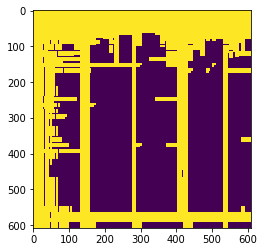

In [423]:
plt.imshow(a[0].T)